# QuantEcon Datascience: Problem Set 8

In this problem set, your goal is to train a model to best predict
log housing values. The criteria for best prediction is mean squared error.
The file ahs.csv contains an extract of data from the [American Housing
Survey](https://www.census.gov/programs-surveys/ahs.html) . As part
of grading this assignment, your predictive model will be evaluated on
another evaluation sample from the same survey. You should create a
function that given an identically formated csv file with all the same
variables, returns the predictions of your model (your function should
not do any refitting of your model on the evaluation sample). In
addition to your code, also answer the questions below.

## Additional Rules

You may not use additional data from the American Housing Survey to
fit your model. You may use data from other sources (although this
is not necessary to recieve a good grade). You may use methods not
covered in this course (although this is also not necessary to recieve
a good grade).

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import (
    linear_model, metrics, neural_network, pipeline,
    model_selection, tree
)
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, pipeline
# load data
ahs = pd.read_csv("ahs-train.csv")
ahs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 151 entries, LOGVALUE to NOWIRE
dtypes: float64(13), int64(138)
memory usage: 2.9 MB


In [98]:
import time
from datetime import timedelta

In [99]:
# dataframe of variable descriptions
# ahs_doc = pd.read_csv("ahs-doc.csv", encoding="latin1")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'max_colwidth', -1):
#     display(ahs_doc[["Variable","Question","Description","Associated.Response.Codes"]])

### Question 1

Create exploratory table(s) and/or visualization(s) to check the data
and help make modelling choices. These need not be very polished.

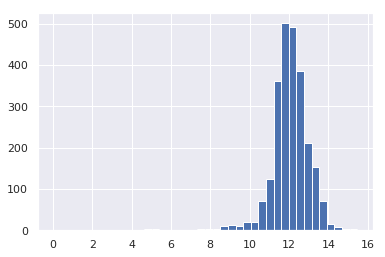

In [100]:
# histogram variable of interest

ahs.head()
ahs['LOGVALUE'].hist(bins=40)

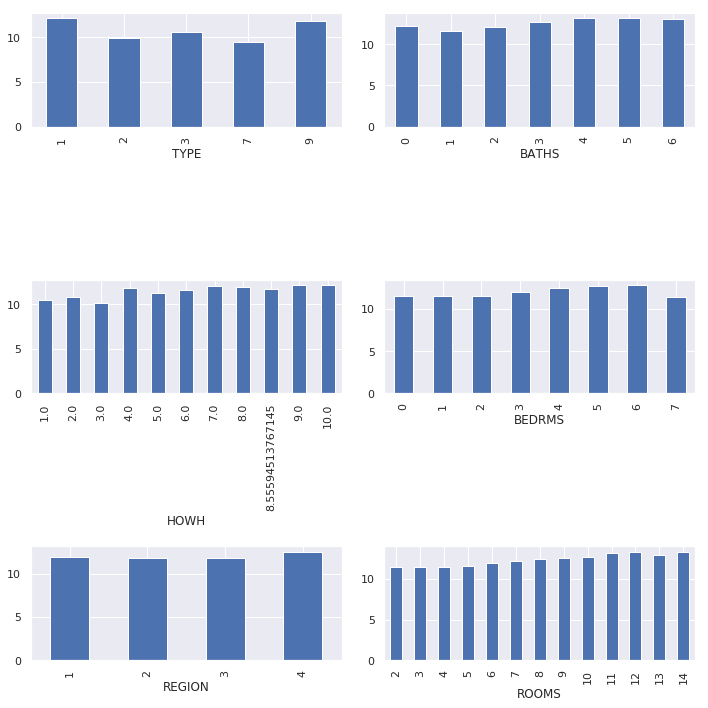

In [101]:
# look at some other variables that I guess would be important

variables = ['TYPE', 'HOWH', 'REGION']
variables2 = ['BATHS', 'BEDRMS', 'ROOMS']
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
for (i, variable) in enumerate(variables) :
    data = ahs.groupby(variable).mean()
    data['LOGVALUE'].plot(kind='bar', ax=ax[i][0])
for (i, variable) in enumerate(variables2) :
    data = ahs.groupby(variable).mean()
    data['LOGVALUE'].plot(kind='bar', ax=ax[i][1])
    
fig.tight_layout()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


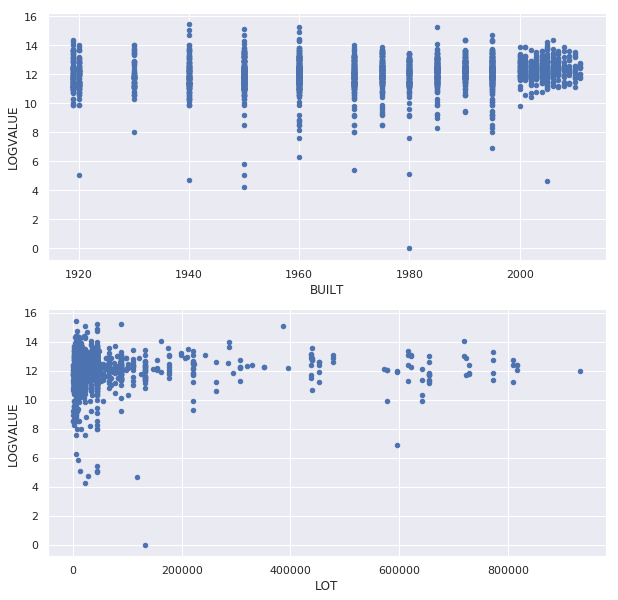

In [102]:
# and a couple more variables

variables = ['BUILT', 'LOT']
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
for (i, variable) in enumerate(variables) :
    ahs.plot(x= variable, y= 'LOGVALUE', kind='scatter', ax=ax[i])

### Question 2

What model will you use for prediction and why you
did you choose this model?

<span style="color:salmon"> 
I chose neural networks because:
- <span style="color:salmon"> Interpretability is probably not an issue for a housing prices dataset. Predictive power is far more important, because people want to be able to negotiate with buyers, and having an accurate prediction of the house's worth is probably useful in that situation. Causality is less of an issue, because the causal variables are likely immutable. For example, if more square footage means a higher house price, I really doubt someone is going to enlarge their house to increase the price by so many dollars. 
- <span style="color:salmon"> The dataset is fairly small (2500 houses) so even though the neural network takes a longer time to process, it probably won't be excessive.
- <span style="color:salmon"> Lasso would likely be good, as I'm sure many of the coefficients are near to zero, but I want to try something harder (as Lasso feels very intuitive)
- <span style="color:salmon"> neural networks sounded cool and 3blue1brown did a great video marketing them :)</span>

### The Model

In [103]:
# borrowing some functions

def var_scatter(df, ax=None, var="LOT"):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))
    df.plot.scatter(x=var , y="LOGVALUE", c='blue', alpha=0.35, s=1.5, ax=ax)

    return ax

def scatter_model(mod, X, ax=None, color="red", x="LOT"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1,)
    return ax

In [104]:
# make our regression variables

X = ahs.drop('LOGVALUE', axis=1).copy()
# convert everything to be a float for later on
for col in list(X):
    X[col] = X[col].astype(float)
X.head()

y=ahs['LOGVALUE']

In [105]:
# Running the model on the full dataset, it looks super well fitted.
# Since we know that overfitting is the Achilles' heel of neural networks,
# we will go ahead and run the data on training and testing subsets so we can check overfitting.

# split into training and testing subsets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

# fit the model
start_time = time.monotonic()

nn_model_prelim = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor((50, 20), solver='lbfgs'))

nn_model_prelim.fit(X_train, y_train)

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:00:28.347954


Training MSE is 0.016959086999928694. Testing MSE is 1.7564432237255672.


Text(0.5, 0.98, 'Testing Data - Neural Network Fit')

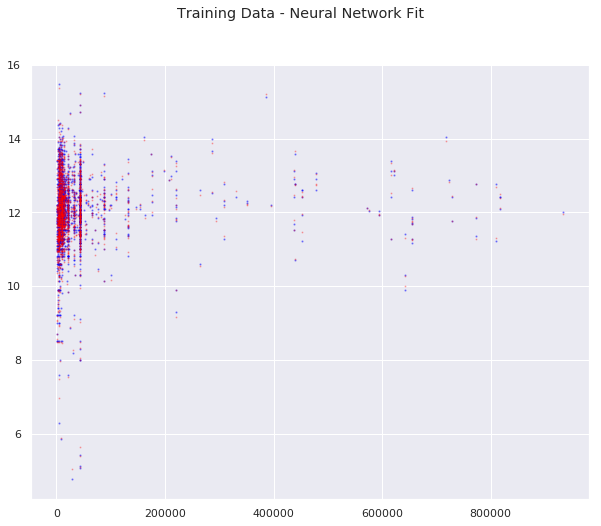

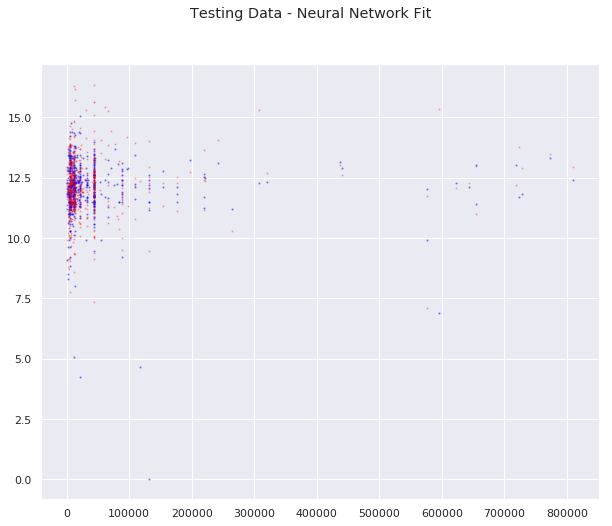

In [106]:
# check the mean squared errors
mse_train=metrics.mean_squared_error(y_train, nn_model_prelim.predict(X_train))
mse_test=metrics.mean_squared_error(y_test, nn_model_prelim.predict(X_test))
print(f"Training MSE is {mse_train}. Testing MSE is {mse_test}.")

# visualize the training data
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=X_train['LOT'] , y=y_train, c='blue', alpha=0.35, s=1.5)
scatter_model(nn_model_prelim, X_train, ax=ax, x='LOT')
fig.suptitle('Training Data - Neural Network Fit')

# visualize the testing data
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(x=X_test['LOT'] , y=y_test, c='blue', alpha=0.35, s=1.5)
scatter_model(nn_model_prelim, X_test, ax=ax1, x='LOT')
fig.suptitle('Testing Data - Neural Network Fit')

In [ ]:
# this is very bad news! It doesn't perform well on the testing data.
# So we will try to improve things for our final model.
# Firstly, increase the number of hidden layers because this seems to improve fit for both datasets.
# Secondly, to compensate for potential over-fitting, we shift alpha.


# the final model
start_time = time.monotonic()

nn_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor((50, 50, 50), alpha=100, solver='lbfgs'))

nn_model.fit(X_train, y_train)

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

# checking the errors
mse_train=metrics.mean_squared_error(y_train, nn_model.predict(X_train))
mse_test=metrics.mean_squared_error(y_test, nn_model.predict(X_test))
print(f"Training MSE is {mse_train}. Testing MSE is {mse_test}.")

In [108]:
# that was better. Our training data has a worse MSE, but the test data is better.

# let's check this performance against a plain linear model.
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

# check errors
mse_train=metrics.mean_squared_error(y_train, lr_model.predict(X_train))
mse_test=metrics.mean_squared_error(y_test, lr_model.predict(X_test))
print(f"Training MSE is {mse_train}. Testing MSE is {mse_test}.")

# hooray! It looks like an improvement, although the execution time tradeoff is REALLY not worth it in this case.
# We will keep this as our final model, although it's not ideal.

Training MSE is 0.4433028430426566. Testing MSE is 0.9120577078522397.


In [109]:
# this code helps find some perfect parameters, but it takes **forever** to execute

# parameter_space = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'logistic'],
#     'alpha': [30, 60, 90],
#     #'learning_rate': ['constant','adaptive'],
# }

# from sklearn.neural_network import MLPRegressor
# mlp = MLPRegressor(solver='lbfgs')
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train)

### Question 3

Briefly describe how you chose any regularization and other parameters
in your model.

<span style='color:salmon'>
    Basically, the model didn't fit the testing data very well. So I scaled up alpha until it seemed like a better fit. I tried to do this in a more scientific way (ie., building a simulation of the mean squared errors under different alpha, or using GridSearchCV) but running this model takes an incredibly long time and I haven't figured out how to make it faster, so this had to do.
<\span>
    

### Question 4

What have you done to avoid overfitting?

<span style='color:salmon'>
    Regularization.
<\span>
    

### Question 5

Create a visualization to aid in the evaluation of your model. This
visualization could be part of your answer to questions 2-4, or it
could simply summarize the predictive accuracy of your model.

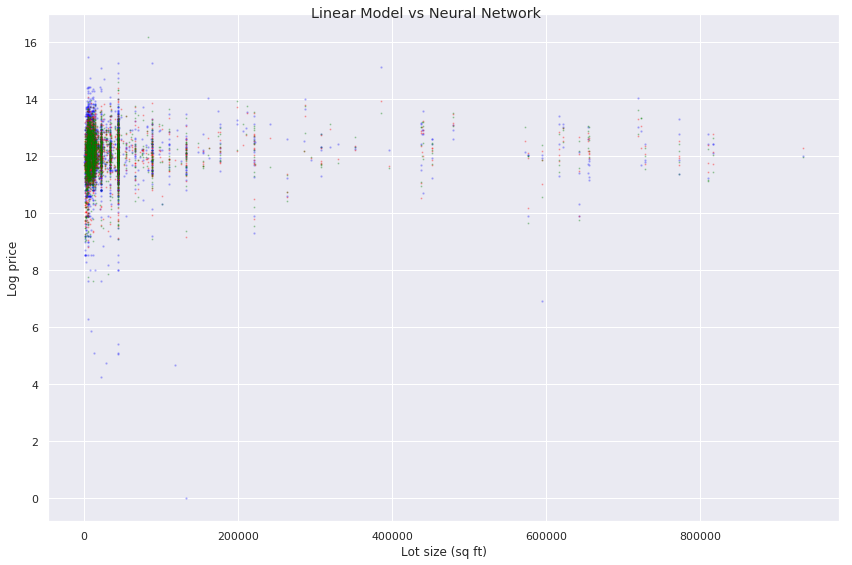

In [110]:
# Here is a visualization of all the data, fitted by the neural network model and the linear model, respectively.

# visualize linear model
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=X['LOT'] , y=y, c='blue', alpha=0.2, s=2)
scatter_model(nn_model, X, ax=ax, x='LOT', color='red')
scatter_model(lr_model, X, ax=ax, x='LOT', color='green')
fig.suptitle('Linear Model vs Neural Network')
ax.set_ylabel('Log price')
ax.set_xlabel('Lot size (sq ft)')
fig.tight_layout()

# Although it's barely visible, one can see that the red (neural network model) fits better than the green (linear model)